# Word2Vec then RNN

## Imports and setting up TensorBoard

In [29]:
from data_preparation import *
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, TimeDistributed, Dropout, Embedding
from keras.optimizers import Adam
from keras_train_helper import tfauc, rotateTensorboardLogs, PrintAucCallback, plotLearningCurve
from keras.regularizers import L1L2
from tensorflow.python.client import device_lib
from keras.callbacks import TensorBoard
from keras.layers import Conv1D, GlobalMaxPool1D, Dropout

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12181045498339135117
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 584318976
locality {
  bus_id: 1
}
incarnation: 12907915996672366558
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1e.0, compute capability: 7.0"
]


## Loading data and setting up preprocessing tools

In [30]:
train, test, allData, contestTest = loadData()

Loading datasets...
train: (127656, 8), test: (31915, 8), allData: (159571, 8), contestTest: (153164, 2)


### Split sentences and apply word correction & splitting

In [31]:
%%time
from sklearn.pipeline import Pipeline

maxSeqLength = 250

splitter = SentenceSplitter("comment_text")
stopwordsRemover = StopwordsRemover()
wordEmbedding = loadWordEmbedding("../../state/external-models/glove.6B/webcrawl.bin")

allWords = splitter.transform(pd.concat([allData, contestTest]))
textWords = set([word for sentence in allWords for word in sentence])
missingWords = textWords - set(list(wordEmbedding.vocab.keys()))

missingWordsResolutionDict = loadObject("./missingWordsResolution.plk")
missingWordsResolver = MissingWordsResolver(missingWordsResolutionDict, missingWords)

splittingPipeline = Pipeline(steps=[
    ("split", splitter),
#     ("removeStopwords", stopwordsRemover),
    ("resolveMissingWords", missingWordsResolver) ])

Splitting sentences...
CPU times: user 17 s, sys: 492 ms, total: 17.5 s
Wall time: 17.4 s


### W2I and zero padding

In [32]:
%%time
resolvedWords = missingWordsResolver.transform(allWords)

w2i = Word2Int(resolvedWords)
zeroPadder = ZeroPadder(maxSeqLength)

indexingPipeline = Pipeline(steps=[
    ("w2i", w2i),
    ("zeroPadding", zeroPadder)
])

Resolving missing words...
Loading w2i and i2w dictionaries...
CPU times: user 9 s, sys: 72 ms, total: 9.07 s
Wall time: 9.06 s


In [33]:
preparationPipeline = Pipeline(steps=[
    ("splittingPipeline", splittingPipeline),
    ("indexingPipeline", indexingPipeline)
])

### W2V

In [57]:
%%time
w2v = Word2Vec(wordEmbedding, 300, w2i.i2w, seed=4324)

Loading word2vec dictionary...
CPU times: user 96 ms, sys: 0 ns, total: 96 ms
Wall time: 97.7 ms


In [58]:
embeddingMatrix, i2v = w2v.embeddingMatrix()

## Define the model

### Define the model

In [65]:
lstmUnits = 100
numClasses = 2
batchSize = 1024

def defineModel(dropout, recurrent_dropout, cnn_dropout):
    model = Sequential()

    model.add(Embedding(
        embeddingMatrix.shape[0],
        embeddingMatrix.shape[1],
        weights=[embeddingMatrix],
        input_length=maxSeqLength,
        trainable=False))

    model.add(LSTM(
        lstmUnits, 
        dropout=dropout, 
        recurrent_dropout=recurrent_dropout, 
        return_sequences=True,
        name="LSTM"))

    model.add(Conv1D(
            100, 
            3, 
            padding = "valid",
            activation = "relu",
            strides = 1))
    
    model.add(GlobalMaxPool1D())
    
    model.add(Dropout(cnn_dropout))
    
    model.add(Dense(
        2, 
        activation="softmax", 
        name="softmax_output"))
    
    model.compile(
        loss="categorical_crossentropy", 
        optimizer="nadam", 
        metrics=[tfauc])

    print(model.summary())
    return model

## Prepare data and train the model

In [66]:
def fitModel(model, trainDataset, testDataset, printAucCallback, label, epochs, fast=False):
    print("Training model for target variable: {}".format(label))
    
    tf.set_random_seed(43245)
    np.random.seed(453252)
    
    labelizer = Labelizer(label)
    oversampler = Oversampler(label)
    
    trainOversampled = oversampler.transform(trainDataset)

    trainSentences = preparationPipeline.transform(trainOversampled)
    trainLabels = labelizer.transform(trainOversampled)
    testSentences = preparationPipeline.transform(testDataset)
    testLabels = labelizer.transform(testDataset)

    printAucCallback.setDatasets([trainSentences, trainLabels], [testSentences, testLabels])

    model.fit(
        trainSentences, 
        trainLabels, 
        nb_epoch=epochs, 
        batch_size=batchSize,
        callbacks=[] if fast else [printAucCallback])
    
    return model, testSentences, testLabels

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 250, 300)          59773200  
_________________________________________________________________
LSTM (LSTM)                  (None, 250, 100)          160400    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 248, 100)          30100     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 100)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
softmax_output (Dense)       (None, 2)                 202       
Total params: 59,963,902
Trainable params: 190,702
Non-trainable params: 59,773,200
__________________________________________________________

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/10
 50176/237771 [=====>........................] - ETA: 1:18 - loss: 0.4013 - tfauc: 0.7935 - train auc: 0.9716
 - test auc: 0.9723
101376/237771 [===========>..................] - ETA: 1:00 - loss: 0.3355 - tfauc: 0.8568 - train auc: 0.9750
 - test auc: 0.9752
152576/237771 [==================>...........] - ETA: 38s - loss: 0.3075 - tfauc: 0.8838 - train auc: 0.9768
 - test auc: 0.9766
203776/237771 [========================>.....] - ETA: 15s - loss: 0.2888 - tfauc: 0.8994 - train auc: 0.9790
 - test auc: 0.9790
237568/237771 [============================>.] - ETA: 0s - loss: 0.2799 - tfauc: 0.9067 - train auc: 0.9796
 - test auc: 0.9796


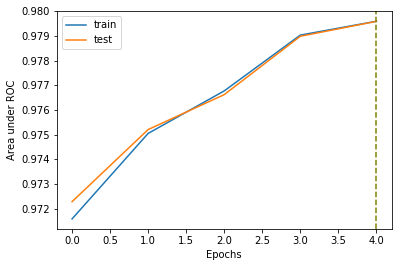

237771/237771 [==============================] - 112s 470us/step - loss: 0.2798 - tfauc: 0.9068
Epoch 2/10
 50176/237771 [=====>........................] - ETA: 1:16 - loss: 0.2196 - tfauc: 0.9542 - train auc: 0.9815
 - test auc: 0.9812
101376/237771 [===========>..................] - ETA: 59s - loss: 0.2167 - tfauc: 0.9558 - train auc: 0.9823
 - test auc: 0.9814
152576/237771 [==================>...........] - ETA: 37s - loss: 0.2139 - tfauc: 0.9571 - train auc: 0.9833
 - test auc: 0.9825
203776/237771 [========================>.....] - ETA: 15s - loss: 0.2114 - tfauc: 0.9582 - train auc: 0.9841
 - test auc: 0.9830
237568/237771 [============================>.] - ETA: 0s - loss: 0.2107 - tfauc: 0.9589 - train auc: 0.9842
 - test auc: 0.9829


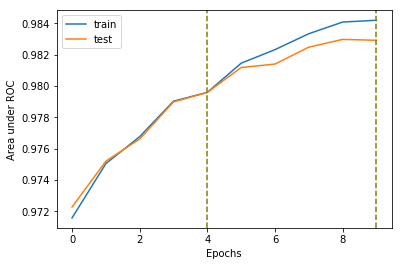

237771/237771 [==============================] - 111s 467us/step - loss: 0.2106 - tfauc: 0.9589
Epoch 3/10
 50176/237771 [=====>........................] - ETA: 1:15 - loss: 0.1990 - tfauc: 0.9639 - train auc: 0.9845
 - test auc: 0.9828
101376/237771 [===========>..................] - ETA: 58s - loss: 0.1980 - tfauc: 0.9645 - train auc: 0.9851
 - test auc: 0.9836
152576/237771 [==================>...........] - ETA: 37s - loss: 0.1967 - tfauc: 0.9651 - train auc: 0.9857
 - test auc: 0.9839
203776/237771 [========================>.....] - ETA: 15s - loss: 0.1948 - tfauc: 0.9656 - train auc: 0.9859
 - test auc: 0.9839
237568/237771 [============================>.] - ETA: 0s - loss: 0.1944 - tfauc: 0.9659 - train auc: 0.9862
 - test auc: 0.9841


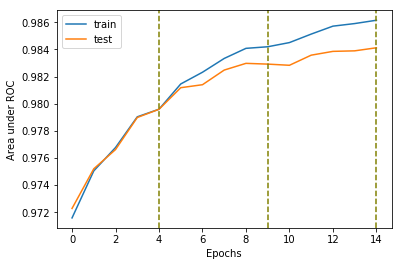

237771/237771 [==============================] - 111s 465us/step - loss: 0.1944 - tfauc: 0.9659
Epoch 4/10
 50176/237771 [=====>........................] - ETA: 1:15 - loss: 0.1873 - tfauc: 0.9685 - train auc: 0.9865
 - test auc: 0.9845
101376/237771 [===========>..................] - ETA: 58s - loss: 0.1848 - tfauc: 0.9688 - train auc: 0.9867
 - test auc: 0.9844
152576/237771 [==================>...........] - ETA: 37s - loss: 0.1837 - tfauc: 0.9692 - train auc: 0.9871
 - test auc: 0.9847
203776/237771 [========================>.....] - ETA: 15s - loss: 0.1824 - tfauc: 0.9695 - train auc: 0.9876
 - test auc: 0.9848
237568/237771 [============================>.] - ETA: 0s - loss: 0.1817 - tfauc: 0.9697 - train auc: 0.9878
 - test auc: 0.9849


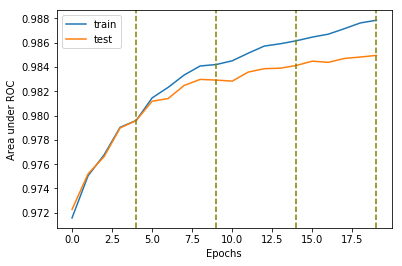

237771/237771 [==============================] - 111s 465us/step - loss: 0.1816 - tfauc: 0.9697
Epoch 5/10
 50176/237771 [=====>........................] - ETA: 1:16 - loss: 0.1721 - tfauc: 0.9715 - train auc: 0.9878
 - test auc: 0.9850
101376/237771 [===========>..................] - ETA: 59s - loss: 0.1718 - tfauc: 0.9718 - train auc: 0.9883
 - test auc: 0.9850
152576/237771 [==================>...........] - ETA: 37s - loss: 0.1728 - tfauc: 0.9720 - train auc: 0.9882
 - test auc: 0.9850
203776/237771 [========================>.....] - ETA: 15s - loss: 0.1730 - tfauc: 0.9723 - train auc: 0.9883
 - test auc: 0.9851
237568/237771 [============================>.] - ETA: 0s - loss: 0.1720 - tfauc: 0.9724 - train auc: 0.9886
 - test auc: 0.9850


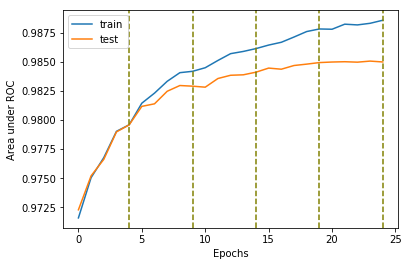

237771/237771 [==============================] - 111s 466us/step - loss: 0.1720 - tfauc: 0.9724
Epoch 6/10
 50176/237771 [=====>........................] - ETA: 1:15 - loss: 0.1678 - tfauc: 0.9736 - train auc: 0.9887
 - test auc: 0.9850
101376/237771 [===========>..................] - ETA: 58s - loss: 0.1661 - tfauc: 0.9739 - train auc: 0.9892
 - test auc: 0.9850
152576/237771 [==================>...........] - ETA: 37s - loss: 0.1663 - tfauc: 0.9741 - train auc: 0.9895
 - test auc: 0.9852
203776/237771 [========================>.....] - ETA: 15s - loss: 0.1663 - tfauc: 0.9742 - train auc: 0.9896
 - test auc: 0.9853
237568/237771 [============================>.] - ETA: 0s - loss: 0.1665 - tfauc: 0.9744 - train auc: 0.9896
 - test auc: 0.9853


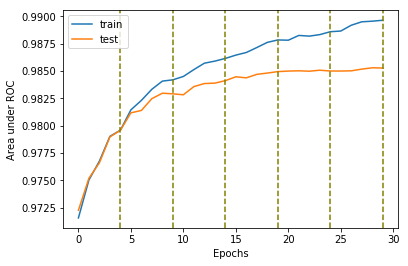

237771/237771 [==============================] - 111s 466us/step - loss: 0.1665 - tfauc: 0.9744
Epoch 7/10
 50176/237771 [=====>........................] - ETA: 1:16 - loss: 0.1563 - tfauc: 0.9753 - train auc: 0.9899
 - test auc: 0.9854
101376/237771 [===========>..................] - ETA: 58s - loss: 0.1619 - tfauc: 0.9755 - train auc: 0.9901
 - test auc: 0.9854
152576/237771 [==================>...........] - ETA: 37s - loss: 0.1620 - tfauc: 0.9756 - train auc: 0.9902
 - test auc: 0.9854
203776/237771 [========================>.....] - ETA: 15s - loss: 0.1619 - tfauc: 0.9758 - train auc: 0.9904
 - test auc: 0.9853
237568/237771 [============================>.] - ETA: 0s - loss: 0.1615 - tfauc: 0.9758 - train auc: 0.9905
 - test auc: 0.9852


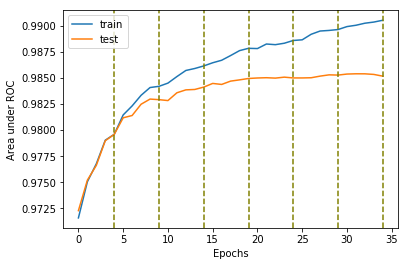

237771/237771 [==============================] - 111s 466us/step - loss: 0.1615 - tfauc: 0.9758
Epoch 8/10
 50176/237771 [=====>........................] - ETA: 1:15 - loss: 0.1568 - tfauc: 0.9766 - train auc: 0.9908
 - test auc: 0.9854
101376/237771 [===========>..................] - ETA: 58s - loss: 0.1568 - tfauc: 0.9767 - train auc: 0.9907
 - test auc: 0.9852
152576/237771 [==================>...........] - ETA: 37s - loss: 0.1580 - tfauc: 0.9769 - train auc: 0.9910
 - test auc: 0.9855
203776/237771 [========================>.....] - ETA: 15s - loss: 0.1571 - tfauc: 0.9770 - train auc: 0.9910
 - test auc: 0.9854
237568/237771 [============================>.] - ETA: 0s - loss: 0.1570 - tfauc: 0.9770 - train auc: 0.9909
 - test auc: 0.9854


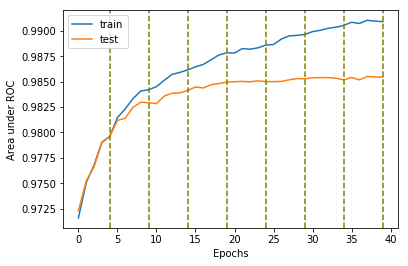

237771/237771 [==============================] - 111s 465us/step - loss: 0.1571 - tfauc: 0.9770
Epoch 9/10
 50176/237771 [=====>........................] - ETA: 1:15 - loss: 0.1534 - tfauc: 0.9777 - train auc: 0.9914
 - test auc: 0.9857
101376/237771 [===========>..................] - ETA: 58s - loss: 0.1528 - tfauc: 0.9778 - train auc: 0.9915
 - test auc: 0.9856
152576/237771 [==================>...........] - ETA: 37s - loss: 0.1517 - tfauc: 0.9779 - train auc: 0.9918
 - test auc: 0.9856
203776/237771 [========================>.....] - ETA: 15s - loss: 0.1515 - tfauc: 0.9780 - train auc: 0.9916
 - test auc: 0.9854
237568/237771 [============================>.] - ETA: 0s - loss: 0.1513 - tfauc: 0.9781 - train auc: 0.9918
 - test auc: 0.9857


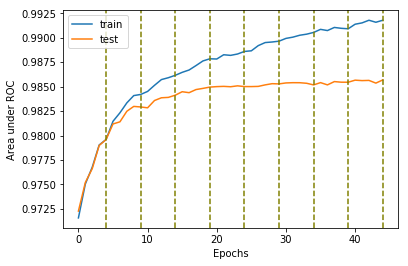

237771/237771 [==============================] - 111s 466us/step - loss: 0.1513 - tfauc: 0.9781
Epoch 10/10
 50176/237771 [=====>........................] - ETA: 1:16 - loss: 0.1473 - tfauc: 0.9786 - train auc: 0.9919
 - test auc: 0.9856
101376/237771 [===========>..................] - ETA: 59s - loss: 0.1487 - tfauc: 0.9787 - train auc: 0.9921
 - test auc: 0.9856
152576/237771 [==================>...........] - ETA: 37s - loss: 0.1490 - tfauc: 0.9788 - train auc: 0.9924
 - test auc: 0.9856
203776/237771 [========================>.....] - ETA: 15s - loss: 0.1489 - tfauc: 0.9789 - train auc: 0.9924
 - test auc: 0.9858
237568/237771 [============================>.] - ETA: 0s - loss: 0.1489 - tfauc: 0.9790 - train auc: 0.9921
 - test auc: 0.9855


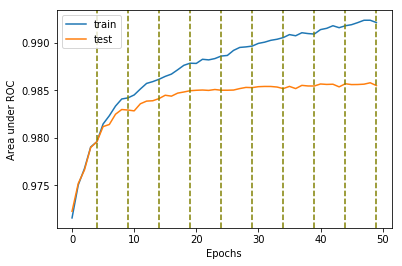

237771/237771 [==============================] - 111s 466us/step - loss: 0.1489 - tfauc: 0.9790
CPU times: user 27min, sys: 4min 21s, total: 31min 22s
Wall time: 18min 51s


In [95]:
%%time
dropout = 0.7
recurrentDropout = 0.4

cnnDropout = 0.5
model = defineModel(dropout, recurrentDropout, cnnDropout)
printAucCallback = PrintAucCallback(8192, printFrequency=0.02)

model, testSentences, testLabels = fitModel(model, train, test, printAucCallback, "toxic", 10)

## Query cell state and cell output

In [71]:
from keras.layers import Input
from keras.models import Model

In [72]:
inputLayer = Input(shape=(maxSeqLength,))

embeddingLayer = Embedding(
    embeddingMatrix.shape[0],
    embeddingMatrix.shape[1],
    weights=[embeddingMatrix],
    input_length=maxSeqLength,
    trainable=False)(inputLayer)

lstmOutput, _, stateC = LSTM(
        lstmUnits, 
        dropout=dropout, 
        recurrent_dropout=recurrentDropout, 
        weights=model.layers[1].get_weights(),
        return_state=True,
        name="LSTM_get_outputs")(embeddingLayer)

outputModel = Model(inputs=inputLayer, outputs=lstmOutput)
cellStateModel = Model(inputs=inputLayer, outputs=stateC)

In [73]:
def outputs(sentence):
    preparedSentence = preparationPipeline.transform(pd.DataFrame([sentence], columns=["comment_text"]))
    return [modelX.predict(preparedSentence) for modelX in [outputModel, cellStateModel]]

## Plot network

In [74]:
%%time
outputPredictions = outputModel.predict(testSentences, batch_size=8192)
cellStatePredictions = cellStateModel.predict(testSentences, batch_size=8192)

def normalizeVector(v, minimum, maximum):
    return (v - minimum) / (maximum - minimum)

def normalizeOutput(v):
    return normalizeVector(v, outputPredictions.min(), outputPredictions.max())

def normalizeCellState(v):
    return normalizeVector(v, cellStatePredictions.min(), cellStatePredictions.max())

CPU times: user 1.96 s, sys: 544 ms, total: 2.51 s
Wall time: 2.46 s


In [75]:
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.pyplot import text

def plotActivations(sentence):
    outputActivations, cellStateActivations = outputs(sentence)
    
    plt.clf()
    plt.figure(figsize=(20, 5))

    cellStates =[Rectangle(
            (i / lstmUnits, 0.4), 
            1 / lstmUnits, 
            0.2, 
            alpha=a, 
            color="navy") 
         for (i, a) in zip(range(lstmUnits), normalizeCellState(cellStateActivations[0]))]

    cellOutputs =[Rectangle(
            (i / lstmUnits, 0.6), 
            1 / lstmUnits, 
            0.2, 
            alpha=a, 
            color="navy") 
         for (i, a) in zip(range(lstmUnits), normalizeOutput(outputActivations[0]))]

    words = splittingPipeline.transform(pd.DataFrame([sentence], columns=["comment_text"]))[0]
    for (i, word) in zip(range(min(100, len(words))), words):
        text(i/lstmUnits, 0.3, word, fontsize=10, rotation="vertical", ha="left", va="center")

    ax = plt.gca()
    ax.set_axis_off()
    for state in cellStates:
        ax.add_patch(state)

    for output in cellOutputs:
        ax.add_patch(output)
    plt.show()

Splitting sentences...
Resolving missing words...
Converting words to integers...
Zero-padding...
Splitting sentences...
Resolving missing words...


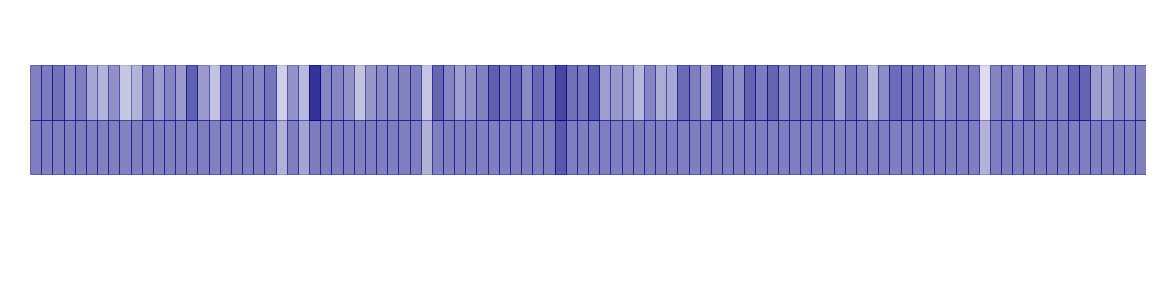

In [87]:
plotActivations("")

Splitting sentences...
Resolving missing words...
Converting words to integers...
Zero-padding...
Splitting sentences...
Resolving missing words...


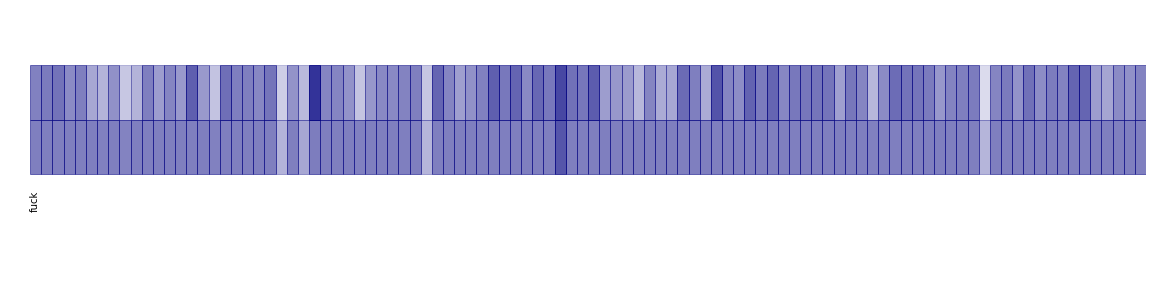

In [85]:
plotActivations("Fuck")

## Visualize best and words predictions

In [88]:
%%time
predictions = model.predict(testSentences, batch_size=4*batchSize)

CPU times: user 1.11 s, sys: 256 ms, total: 1.36 s
Wall time: 1.33 s


In [89]:
def getSortedPredictions(toxic):
    return pd.concat(
            [np.abs(test.toxic - predictions[:, 1]).rename("divergence"), 
             test.toxic, 
             pd.Series(predictions[:, 1], name="pred")], 
        axis=1)[test.toxic == toxic].sort_values(by="divergence")

def bestAndWorst(sortedPredictions):
    best = list(zip(
        test.loc[sortedPredictions[:5].index.tolist()].comment_text, 
        sortedPredictions[:5].to_dict(orient="records")))
    worst = list(zip(
        test.loc[sortedPredictions[-5:].index.tolist()].comment_text, 
        sortedPredictions[-5:].to_dict(orient="records")))
    return best, worst

sortedPredictionsPositive = getSortedPredictions(1)
sortedPredictionsNegative = getSortedPredictions(0)

bestPredictionsPositive, worstPredictionsPositive = bestAndWorst(sortedPredictionsPositive)
bestPredictionsNegative, worstPredictionsNegative = bestAndWorst(sortedPredictionsNegative)

Divergence: {'divergence': 9.298324584960938e-06, 'toxic': 1.0, 'pred': 0.999990701675415}
Splitting sentences...
Resolving missing words...
Converting words to integers...
Zero-padding...
Splitting sentences...
Resolving missing words...


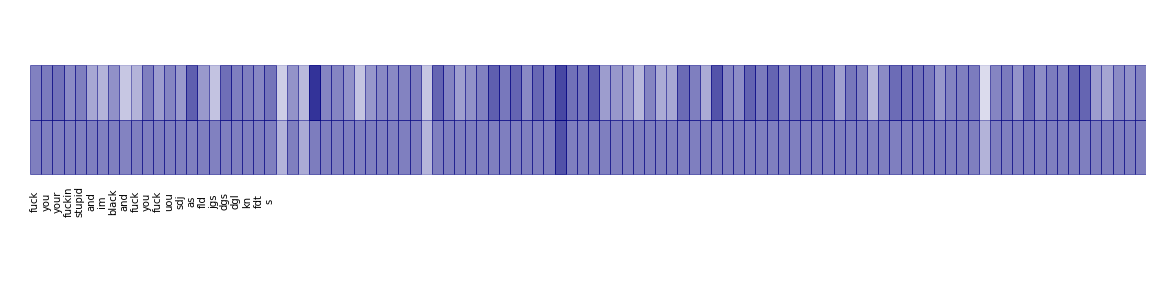

Divergence: {'divergence': 1.0013580322265625e-05, 'toxic': 1.0, 'pred': 0.9999899864196777}
Splitting sentences...
Resolving missing words...
Converting words to integers...
Zero-padding...
Splitting sentences...
Resolving missing words...


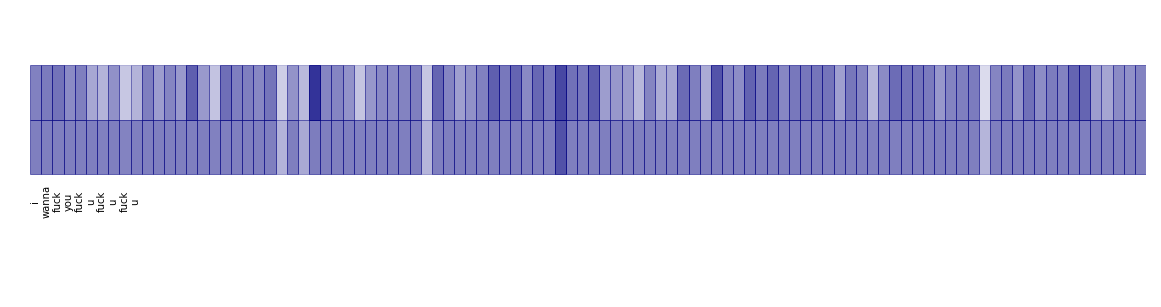

Divergence: {'divergence': 1.0132789611816406e-05, 'toxic': 1.0, 'pred': 0.9999898672103882}
Splitting sentences...
Resolving missing words...
Converting words to integers...
Zero-padding...
Splitting sentences...
Resolving missing words...


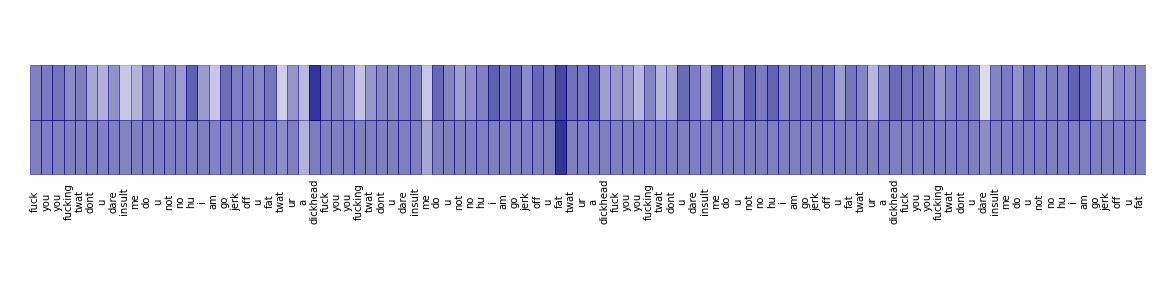

Divergence: {'divergence': 1.0251998901367188e-05, 'toxic': 1.0, 'pred': 0.9999897480010986}
Splitting sentences...
Resolving missing words...
Converting words to integers...
Zero-padding...
Splitting sentences...
Resolving missing words...


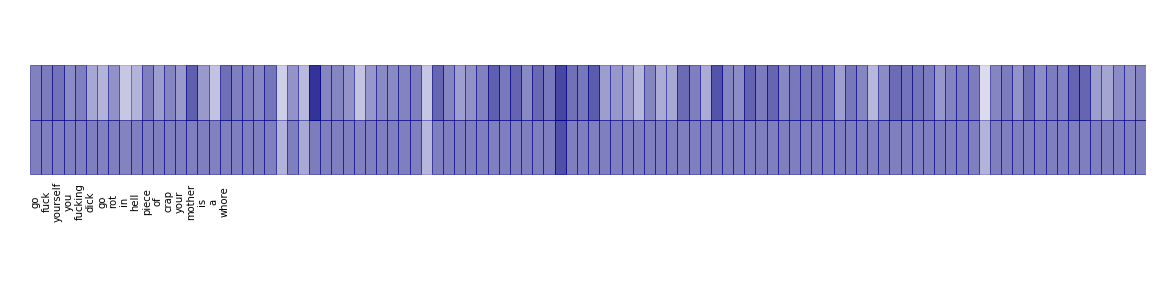

Divergence: {'divergence': 1.049041748046875e-05, 'toxic': 1.0, 'pred': 0.9999895095825195}
Splitting sentences...
Resolving missing words...
Converting words to integers...
Zero-padding...
Splitting sentences...
Resolving missing words...


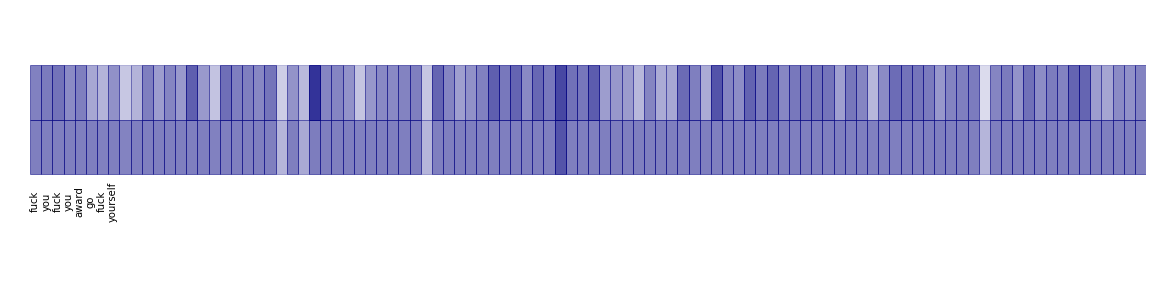

In [90]:
for (sentence, prediction) in bestPredictionsPositive:
    print("Divergence: {}".format(prediction))
    plotActivations(sentence)

Divergence: {'divergence': 0.9758647549897432, 'toxic': 1.0, 'pred': 0.024135245010256767}
Splitting sentences...
Resolving missing words...
Converting words to integers...
Zero-padding...
Splitting sentences...
Resolving missing words...


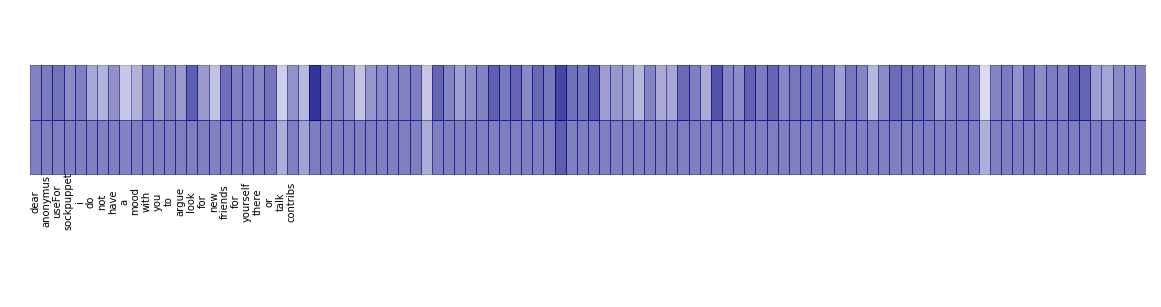

Divergence: {'divergence': 0.978846849873662, 'toxic': 1.0, 'pred': 0.021153150126338005}
Splitting sentences...
Resolving missing words...
Converting words to integers...
Zero-padding...
Splitting sentences...
Resolving missing words...


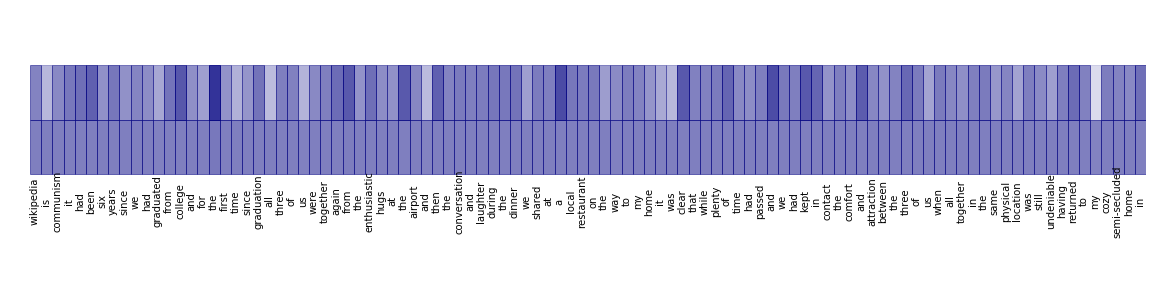

Divergence: {'divergence': 0.979713274165988, 'toxic': 1.0, 'pred': 0.02028672583401203}
Splitting sentences...
Resolving missing words...
Converting words to integers...
Zero-padding...
Splitting sentences...
Resolving missing words...


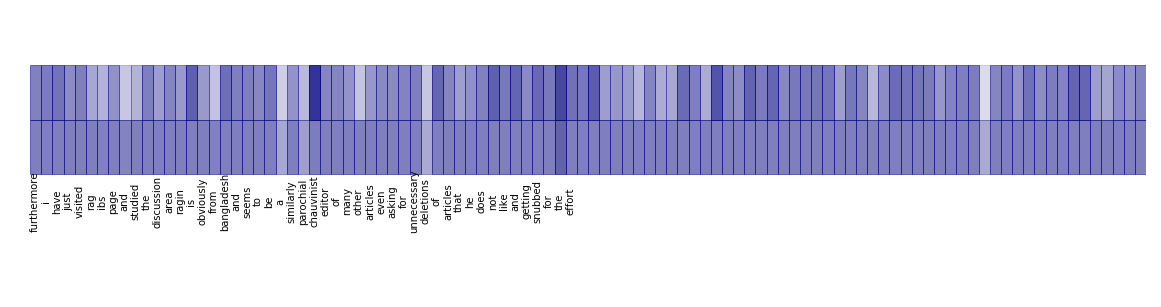

Divergence: {'divergence': 0.9873972563073039, 'toxic': 1.0, 'pred': 0.012602743692696095}
Splitting sentences...
Resolving missing words...
Converting words to integers...
Zero-padding...
Splitting sentences...
Resolving missing words...


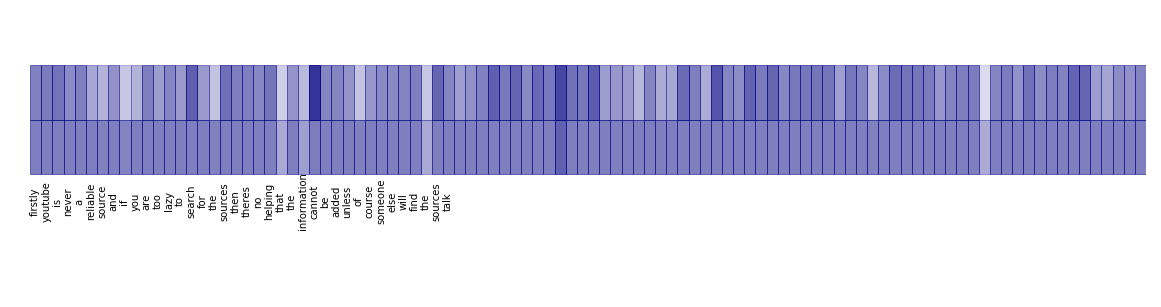

Divergence: {'divergence': 0.9992939844960347, 'toxic': 1.0, 'pred': 0.0007060155039653182}
Splitting sentences...
Resolving missing words...
Converting words to integers...
Zero-padding...
Splitting sentences...
Resolving missing words...


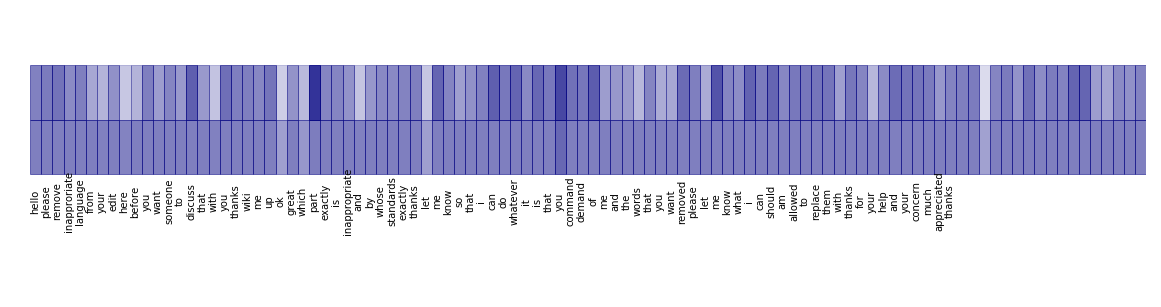

In [91]:
for (sentence, prediction) in worstPredictionsPositive:
    print("Divergence: {}".format(prediction))
    plotActivations(sentence)

Divergence: {'divergence': 0.0001205124644911848, 'toxic': 0.0, 'pred': 0.0001205124644911848}
Splitting sentences...
Resolving missing words...
Converting words to integers...
Zero-padding...
Splitting sentences...
Resolving missing words...


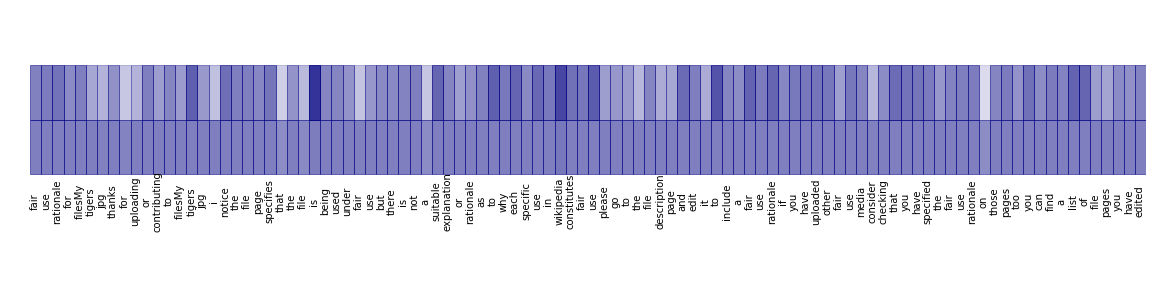

Divergence: {'divergence': 0.00012422217696439475, 'toxic': 0.0, 'pred': 0.00012422217696439475}
Splitting sentences...
Resolving missing words...
Converting words to integers...
Zero-padding...
Splitting sentences...
Resolving missing words...


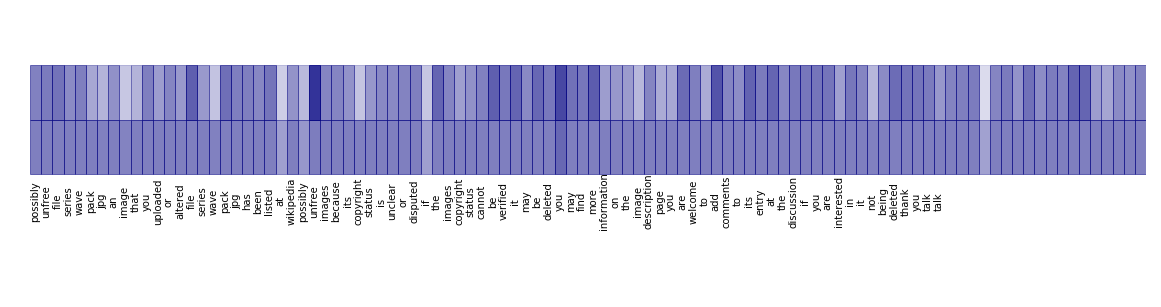

Divergence: {'divergence': 0.00013422430492937565, 'toxic': 0.0, 'pred': 0.00013422430492937565}
Splitting sentences...
Resolving missing words...
Converting words to integers...
Zero-padding...
Splitting sentences...
Resolving missing words...


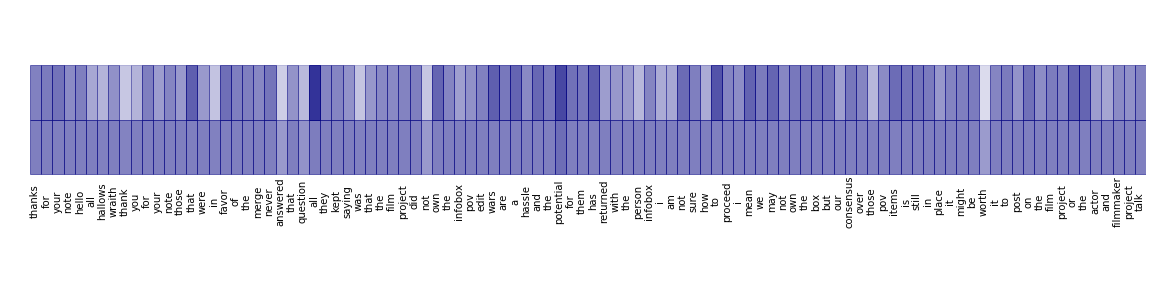

Divergence: {'divergence': 0.00014179928984958678, 'toxic': 0.0, 'pred': 0.00014179928984958678}
Splitting sentences...
Resolving missing words...
Converting words to integers...
Zero-padding...
Splitting sentences...
Resolving missing words...


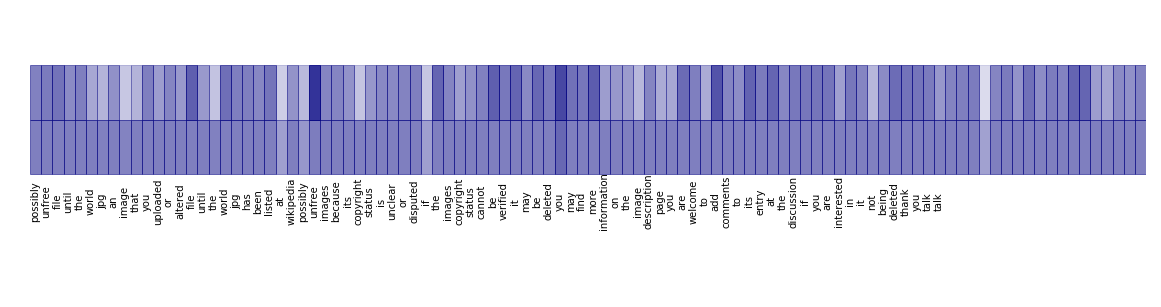

Divergence: {'divergence': 0.0001513503084424883, 'toxic': 0.0, 'pred': 0.0001513503084424883}
Splitting sentences...
Resolving missing words...
Converting words to integers...
Zero-padding...
Splitting sentences...
Resolving missing words...


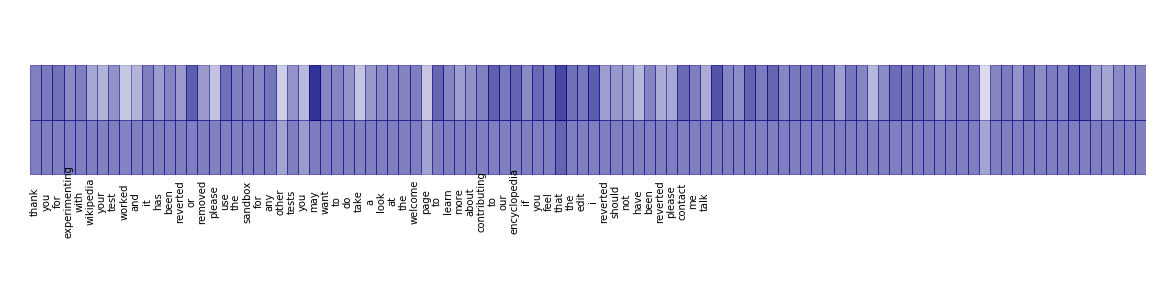

In [92]:
for (sentence, prediction) in bestPredictionsNegative:
    print("Divergence: {}".format(prediction))
    plotActivations(sentence)

Divergence: {'divergence': 0.9996036887168884, 'toxic': 0.0, 'pred': 0.9996036887168884}
Splitting sentences...
Resolving missing words...
Converting words to integers...
Zero-padding...
Splitting sentences...
Resolving missing words...


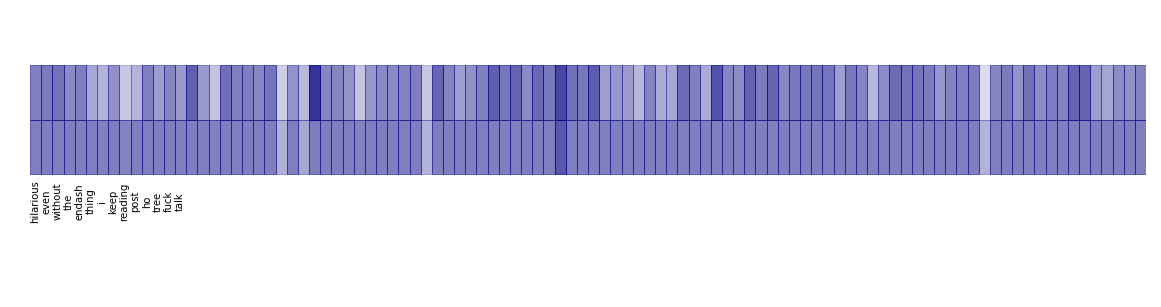

Divergence: {'divergence': 0.9996531009674072, 'toxic': 0.0, 'pred': 0.9996531009674072}
Splitting sentences...
Resolving missing words...
Converting words to integers...
Zero-padding...
Splitting sentences...
Resolving missing words...


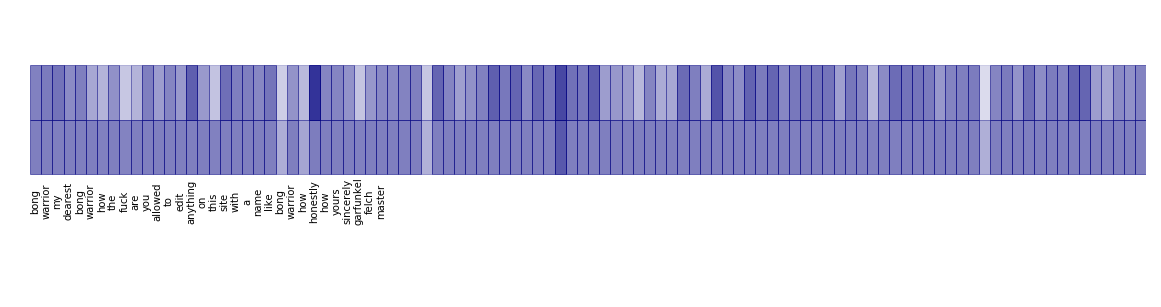

Divergence: {'divergence': 0.9996734857559204, 'toxic': 0.0, 'pred': 0.9996734857559204}
Splitting sentences...
Resolving missing words...
Converting words to integers...
Zero-padding...
Splitting sentences...
Resolving missing words...


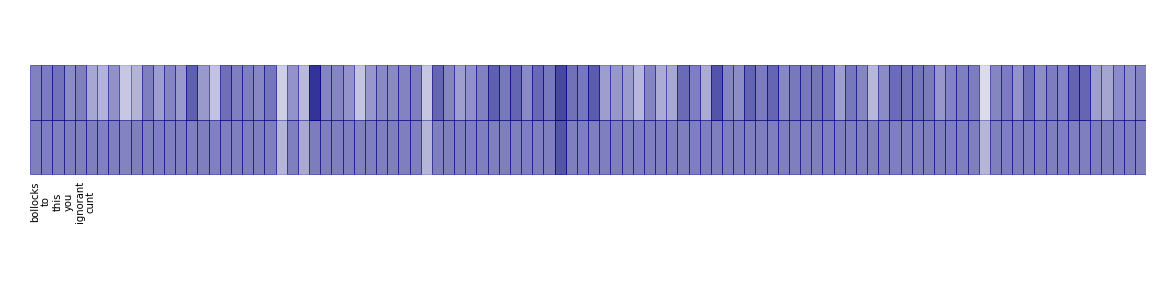

Divergence: {'divergence': 0.9996912479400635, 'toxic': 0.0, 'pred': 0.9996912479400635}
Splitting sentences...
Resolving missing words...
Converting words to integers...
Zero-padding...
Splitting sentences...
Resolving missing words...


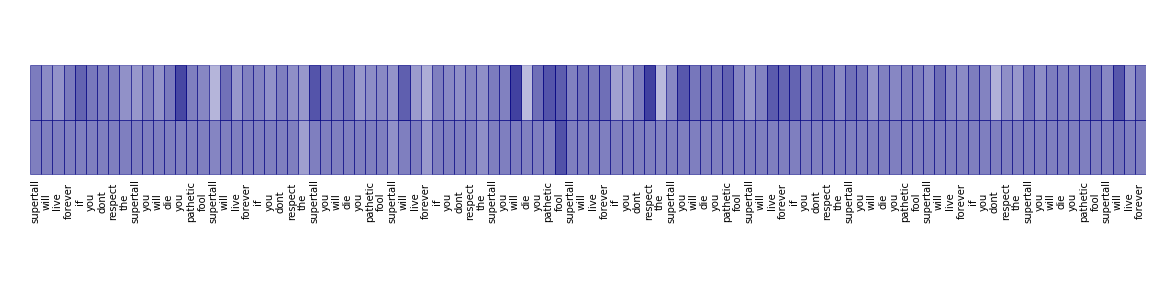

Divergence: {'divergence': 0.9996981620788574, 'toxic': 0.0, 'pred': 0.9996981620788574}
Splitting sentences...
Resolving missing words...
Converting words to integers...
Zero-padding...
Splitting sentences...
Resolving missing words...


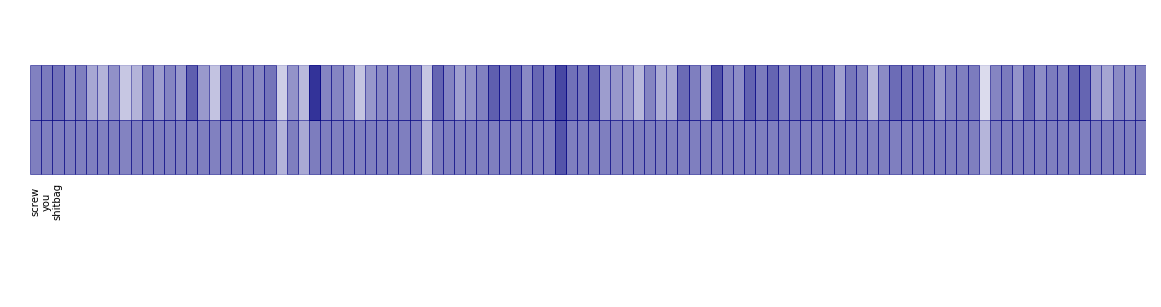

In [93]:
for (sentence, prediction) in worstPredictionsNegative:
    print("Divergence: {}".format(prediction))
    plotActivations(sentence)

## Compare train and test data

In [ ]:
plotLearningCurve(printAucCallback.listOfAucsTrain, printAucCallback.listOfAucsTest)

In [ ]:
%%time
from evaluate_predictions import evaluatePredictions

predictions = model.predict(testSentences, batch_size=4*batchSize)
binaryPredictions = np.where(predictions[:, 1] > 0.5, 1, 0)
labels = testLabels[:, 1]

evaluatePredictions(pd.Series(labels), binaryPredictions, predictions)

## Run on all data and export submission

In [ ]:
%%time
contestModels = [
    fitModel(defineModel(dropout, recurrent_dropout), allData, test, PrintAucCallback(8192, printFrequency=0.02), label, epochs, fast=True)
    for (label, epochs, dropout, recurrent_dropout)
    in [("toxic", 6, 0.7, 0.2), 
        ("severe_toxic", 7, 0.9, 0.2), 
        ("obscene", 7, 0.7, 0.2), 
        ("threat", 7, 0.9, 0.3), 
        ("insult", 6, 0.7, 0.2), 
        ("identity_hate", 6, 0.8, 0.2)]]

In [ ]:
%%time
categories = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
contestPredictionProbabilities = {
    category: model[0].predict(preparationPipeline.transform(contestTest), batch_size=8192) 
    for (category, model) in zip(categories, contestModels)}

In [33]:
suffledResult = pd.DataFrame(dict(
    [("id", contestTest.id)] 
    + [(name, preds[:, 1]) for (name, preds) in contestPredictionProbabilities.items()]))

result = suffledResult[["id"] + categories]

In [34]:
result.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.107428,0.086610,0.179781,0.043975,0.104099,0.086608
1,0000247867823ef7,0.147077,0.124943,0.256728,0.045869,0.097912,0.125053
2,00013b17ad220c46,0.144134,0.122432,0.231361,0.073960,0.156137,0.122611
3,00017563c3f7919a,0.094946,0.076373,0.186833,0.022637,0.050725,0.076566
4,00017695ad8997eb,0.105768,0.083794,0.182512,0.037039,0.066183,0.083650


In [ ]:
result.shape

In [45]:
result.to_csv("./submissions/w2v-then-rnn-increased-dropout.csv", index=False)